In [1]:
### IMPORTS
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import time
import pickle

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip

%matplotlib inline

### Feature extraction functions

In [2]:
def convert_color(img, color_space='RGB'):
    # Convert to color space if different from RGB
    if color_space != 'RGB':
        to_color = getattr(cv2, 'COLOR_RGB2'+color_space)
        conv_image = cv2.cvtColor(img, to_color)
    else:
        conv_image = np.copy(img) 
    return conv_image

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Histogram of each channel separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return feature vector
    return hist_features

def bin_spatial(img, size=(32, 32)):
    # Resize
    image = cv2.resize(img, size)
    # Feature vector
    features = image.ravel()
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec,
                                  block_norm="L2-Hys")
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec,
                       block_norm="L2-Hys")
        return features
    
def extract_features(img_paths, color_space='RGB',
                     png2jpg = True,
                     spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256),
                     pix_per_cell = 8, cell_per_block = 2, orient = 9, hog_channel=0,
                     spatial_feat = True, hist_feat = True, hog_feat = True):
    
    # Create a list to append feature vectors to
    features = []
    
    # for each image path
    for path in img_paths:
        # Read images
        image = mpimg.imread(path)
        # Convert to 0 - 255 image (jpg format)
        if png2jpg:
            image = (image*255).astype(np.uint8)
        # Convert to color space if different from RGB
        if color_space != 'RGB':
            to_color = getattr(cv2, 'COLOR_RGB2'+color_space)
            feature_image = cv2.cvtColor(image, to_color)
        else:
            feature_image = np.copy(image)
        
        # Single image features
        img_features = []
        # Spatial color features
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        # Color histogram
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
        # Hog
        if hog_feat:
            hog_features = []
            if hog_channel == 'ALL':
                channels = [feature_image[:,:,ch] for ch in range(feature_image.shape[2])]
            elif hog_channel == 'GRAY':
                channels = [convert_color(image, 'GRAY')]
            else:
                channels = [feature_image[:,:,hog_channel]]          
            for channel in channels:                     
                hog_features.append(get_hog_features(channel, 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)   
            img_features.append(hog_features)
        
        # Concatenate features and append to feature vector
        features.append(np.concatenate(img_features))
    return features

### Sliding window functions

In [3]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Find cars and filtering functions

In [4]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, color_space,
              svc, X_scaler,
              orient, pix_per_cell, cell_per_block, hog_channels,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    # Crop image to reduce search space,
    # get one copy for spatial and hist features extraction
    # the other to get hog features
    img_tosearch = img[ystart:ystop,:,:]
    hog_tosearch = img_tosearch.copy()
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    
    # Scale the image
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channels == 'ALL':
        channels = [ctrans_tosearch[:,:,ch] for ch in [0,1,2]]
    elif hog_channels == 'GRAY':
        channels = [convert_color(img_tosearch, 'GRAY')]
    else:
        channels = [ctrans_tosearch[:,:,hog_channels]]
    
    full_hog_features = []
    for channel in channels:
        full_hog_features.append(get_hog_features(channel, orient, pix_per_cell, cell_per_block, feature_vec=False))
    
    # list to store features and coordinates of each window
    test_features = []
    test_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_features = []
            for ch_id in range(len(channels)):
                full_hog = full_hog_features[ch_id]
                hog_featx = full_hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features.append(hog_featx)
            hog_features = np.hstack(hog_features)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # save features
            test_features.append(np.hstack((spatial_features, hist_features, hog_features)))
            
            # and windows
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            test_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+ystart+win_draw)))
          
            
    test_features = np.array(test_features)
    test_windows = np.array(test_windows)
            
    # Scale features and make a prediction
    test_features = X_scaler.transform(test_features)    
    #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
    test_prediction = svc.predict(test_features)
    
    # Select positive windows
    positive_windows = test_windows[test_prediction == 1]

    return positive_windows

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_boxes(image, boxes, color = (0,0,255), thickness = 5):
    draw_img = image.copy()
    for top_corner, bottom_corner in boxes:
        cv2.rectangle(draw_img, tuple(top_corner), tuple(bottom_corner), color, thickness)
    return draw_img

def filter_bboxes(img, bbox_list, threshold = 1):
    
    # Create an empty canvas
    heatmap = np.zeros_like(img[:,:,0])
    
    # Iterate through list of list of boxes
    for box_set in bbox_list:
        for box in box_set:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # Filter false positives through thresholding    
    heatmap[heatmap <= threshold] = 0
    
    # identify individual cars
    labels = label(heatmap)
    
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Save the box
        boxes.append(bbox)

    # Return boxes
    return boxes

    cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)

### Class for vehicle tracking through frames

In [6]:
class Counter():

    def __init__(self):
        
        #
        self.counter = 0
        
    def plus(self):
        self.counter += 1
        
    def get_counter(self):
        return self.counter
        

class VehicleTracker():
    
    def __init__(self, find_func, max_memory_len = 5, init_threshold = 1):
        
        #
        self.image = np.array([]).astype(np.uint8)
        self.history = []
        self.max_memory_len = max_memory_len
        self.init_threshold = init_threshold
        self.treshold = self.init_threshold
        self.find_cars_func = find_func
        
    def find_cars(self, image):
        
        self.image = image.copy()
        car_candidates = self.find_cars_func(image)
        self.update_history(car_candidates)
    
    def update_history(self, new_candidates):
        
        if len(self.history) >= self.max_memory_len:
            self.history.pop(0)
        
        self.history.append(new_candidates)
        
    def get_car_candidates(self):
        
        all_boxes = []
        for boxes in self.history:
            all_boxes.extend(boxes)
        return all_boxes
        
    def get_detection(self):
        
        self.treshold = len(self.history) + self.init_threshold
        return filter_bboxes(self.image, self.history, threshold = self.treshold)

### Helper class to save images from video

In [7]:
class ImageSaver():
    
    def __init__(self, save_dir):
        self.counter = 0
        self.save_dir = save_dir
        
    def save_image(self, image):
        save_path = '{}/{}_{:03}.jpg'.format(self.save_dir, 'vid_img', self.counter)
        plt.imsave(save_path, image)
        self.counter += 1
        return image
        
def img_saver(image):
    return imgSaver.save_image(image)

### HOG Features extraction

In [8]:
### LOAD CAR + NON CARS IMAGES (PATHS TO)
car_dirname = ['data-set/vehicles/KITTI_extracted/','data-set/vehicles/GTI_Far/'
               ,'data-set/vehicles/GTI_MiddleClose/','data-set/vehicles/GTI_Left/','data-set/vehicles/GTI_Right/']
notcar_dirname = ['data-set/non-vehicles/Extras/','data-set/non-vehicles/GTI/']

cars = []
for dirname in car_dirname:
    cars.extend(glob.glob(dirname+'*.*'))

notcars = []
for dirname in notcar_dirname:
    notcars.extend(glob.glob(dirname+'*.*'))

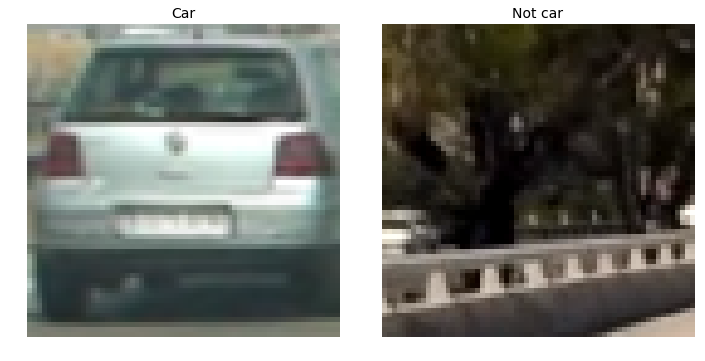

In [9]:
### Car not / car example
np.random.seed(2)
rnd_car_id = np.random.choice(len(cars))
rnd_not_car_id = np.random.choice(len(notcars))

rnd_car = mpimg.imread(cars[rnd_car_id])
rnd_not_car = mpimg.imread(notcars[rnd_not_car_id])

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(10,5))
fig.tight_layout()

ax1.imshow(rnd_car)
ax1.set_title('Car', fontsize = 14)
ax1.axis('off')

ax2.imshow(rnd_not_car)
ax2.set_title('Not car', fontsize = 14)
axis = ax2.axis('off')

fig.savefig('report-images/car-notcar-example')

In [10]:
### Different conbinations to test hog features
lmb_get_hog_5082 = lambda x : get_hog_features(x, orient = 5, pix_per_cell = 8, cell_per_block = 2,
                                          vis=True, feature_vec=True)
lmb_get_hog_9082 = lambda x : get_hog_features(x, orient = 9, pix_per_cell = 8, cell_per_block = 2,
                                          vis=True, feature_vec=True)
lmb_get_hog_5084 = lambda x : get_hog_features(x, orient = 5, pix_per_cell = 8, cell_per_block = 4,
                                          vis=True, feature_vec=True)
lmb_get_hog_9084 = lambda x : get_hog_features(x, orient = 9, pix_per_cell = 8, cell_per_block = 4,
                                          vis=True, feature_vec=True)
lmb_get_hog_5162 = lambda x : get_hog_features(x, orient = 5, pix_per_cell = 16, cell_per_block = 2,
                                          vis=True, feature_vec=True)
lmb_get_hog_9162 = lambda x : get_hog_features(x, orient = 9, pix_per_cell = 16, cell_per_block = 2,
                                          vis=True, feature_vec=True)
lmb_get_hog_5164 = lambda x : get_hog_features(x, orient = 5, pix_per_cell = 16, cell_per_block = 4,
                                          vis=True, feature_vec=True)
lmb_get_hog_9164 = lambda x : get_hog_features(x, orient = 9, pix_per_cell = 16, cell_per_block = 4,
                                          vis=True, feature_vec=True)

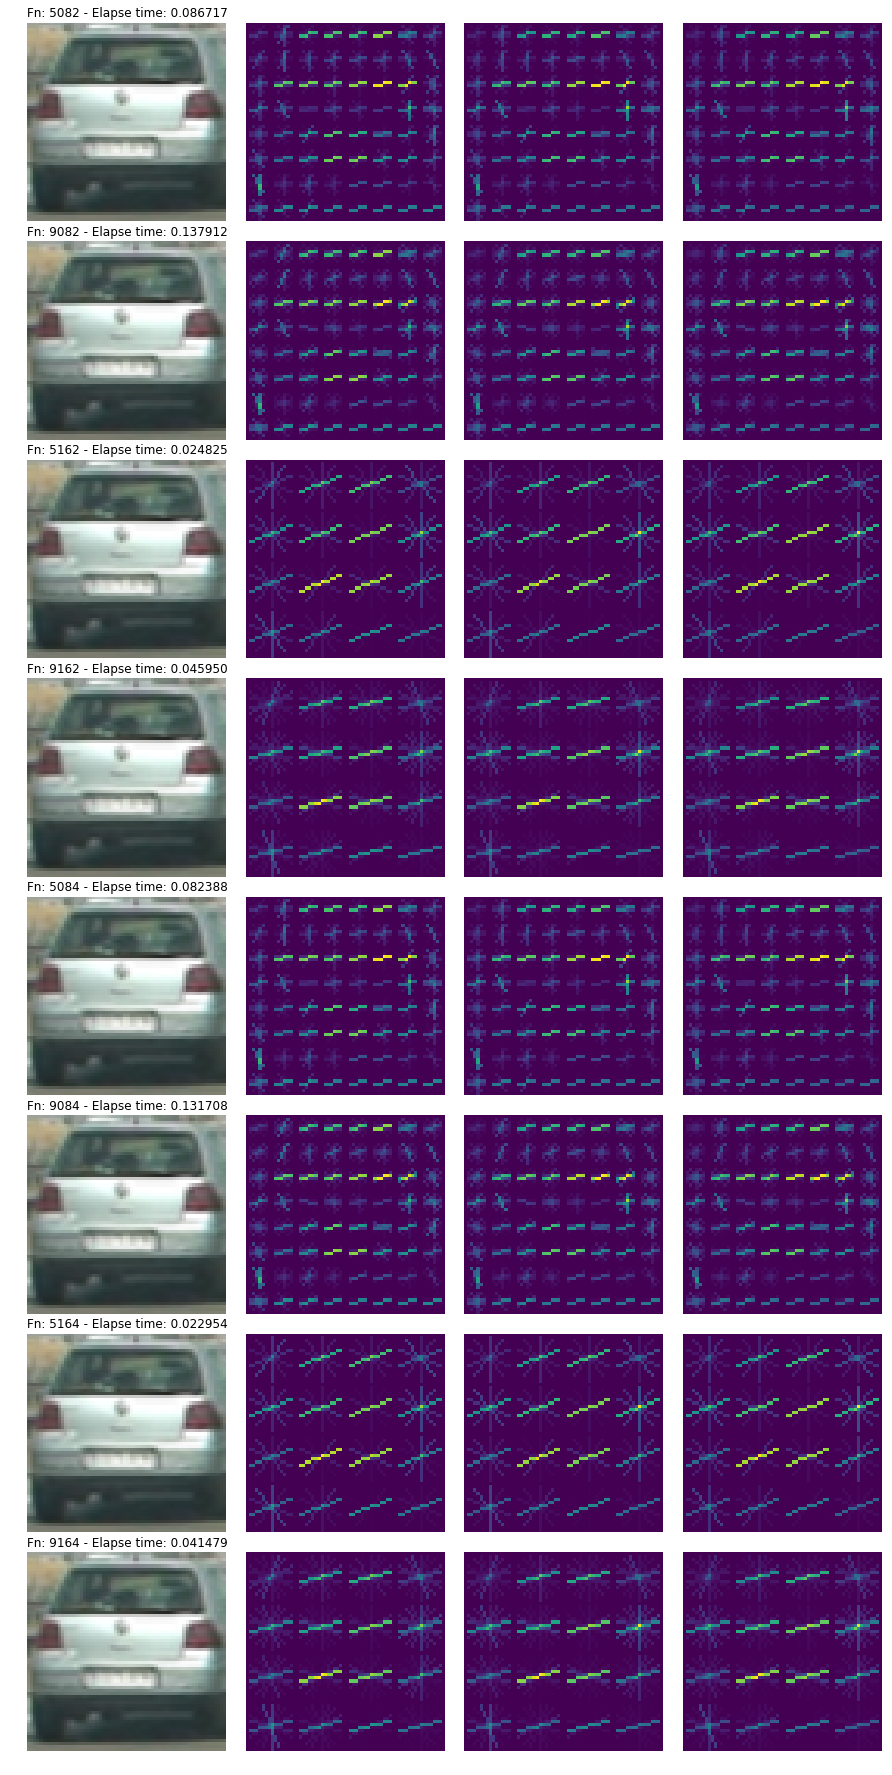

In [11]:
lmb_funs = [lmb_get_hog_5082, lmb_get_hog_9082, lmb_get_hog_5162, lmb_get_hog_9162,
            lmb_get_hog_5084, lmb_get_hog_9084, lmb_get_hog_5164, lmb_get_hog_9164]

lmb_texts = ['5082', '9082', '5162', '9162',
             '5084', '9084', '5164', '9164']

fig, axes = plt.subplots(len(lmb_funs), 4, figsize=(12,24))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.05)

for lmb_fun, lmb_text, ax_line in zip(lmb_funs, lmb_texts, axes):
    ax_line[0].imshow(rnd_car)
    ax_line[0].axis('off')
    start_time = time.time()
    for channel, ax in zip([0,1,2], ax_line[1:]):
        hog_feat, hog_img = lmb_fun(rnd_car[:,:,channel])
        ax.imshow(hog_img)
        ax.axis('off')

    end_time = time.time() - start_time
    ax_line[0].set_title('Fn: {} - Elapse time: {:4f}'.format(lmb_text, end_time), loc='left', fontsize = 12)
fig.savefig('report-images/car-hog-features')

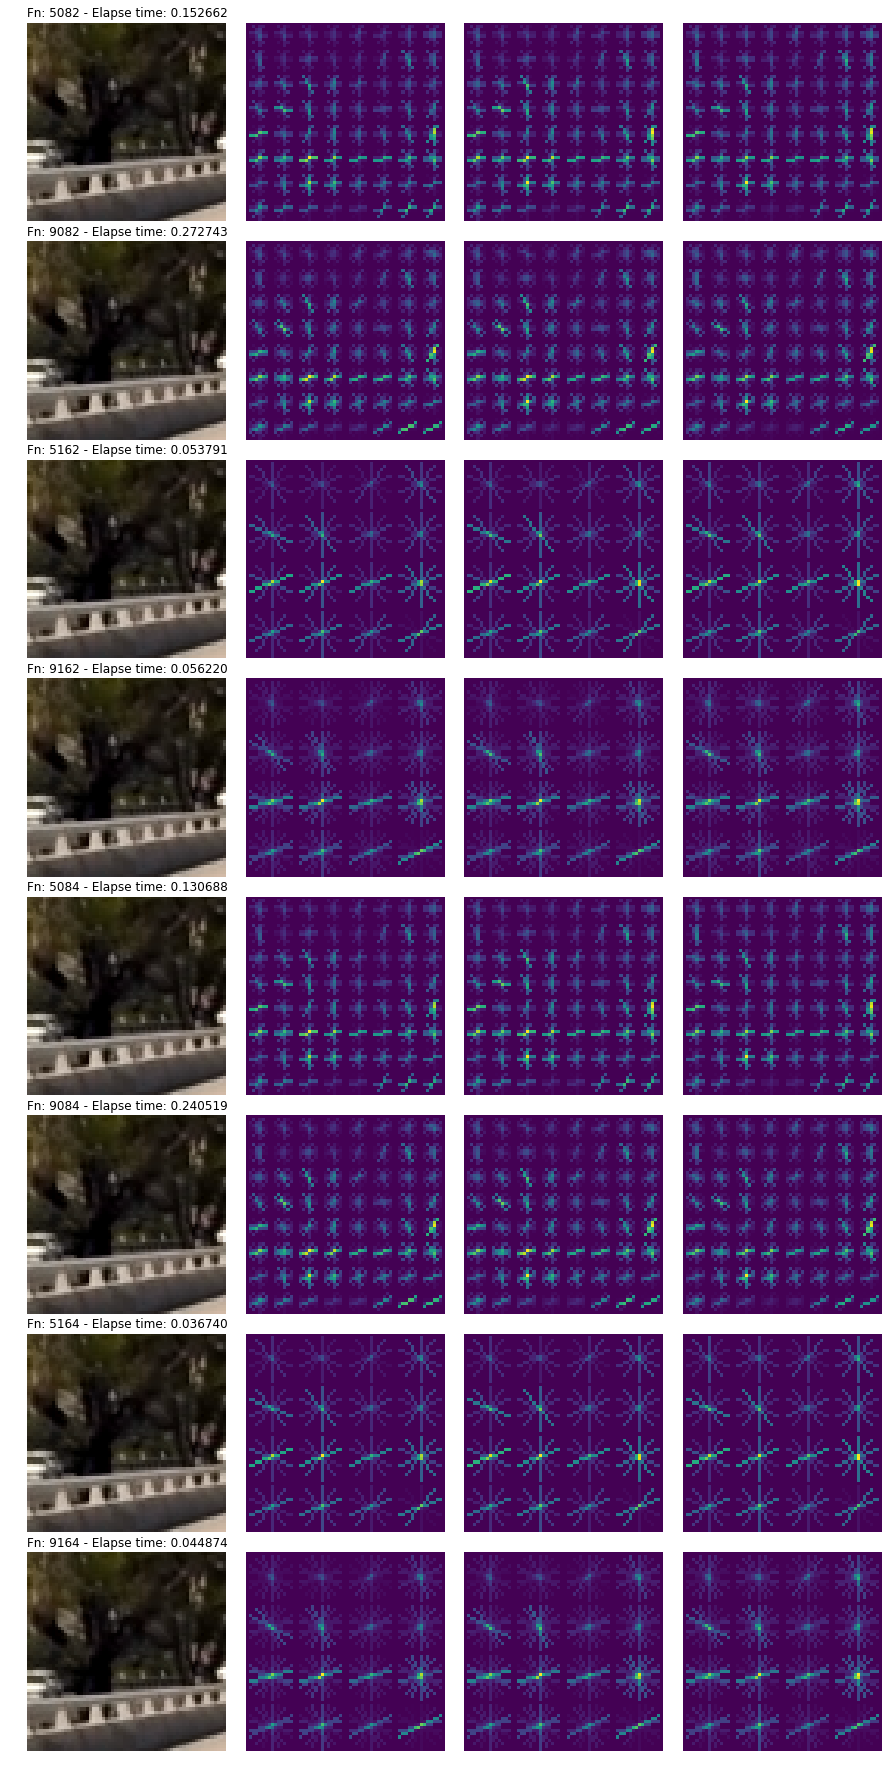

In [12]:
fig, axes = plt.subplots(len(lmb_funs), 4, figsize=(12,24))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.05)

for lmb_fun, lmb_text, ax_line in zip(lmb_funs, lmb_texts, axes):
    ax_line[0].imshow(rnd_not_car)
    ax_line[0].axis('off')
    start_time = time.time()
    for channel, ax in zip([0,1,2], ax_line[1:]):
        hog_feat, hog_img = lmb_fun(rnd_not_car[:,:,channel])
        ax.imshow(hog_img)
        ax.axis('off')

    end_time = time.time() - start_time
    ax_line[0].set_title('Fn: {} - Elapse time: {:4f}'.format(lmb_text, end_time), loc='left', fontsize = 12)
fig.savefig('report-images/not-car-hog-features')

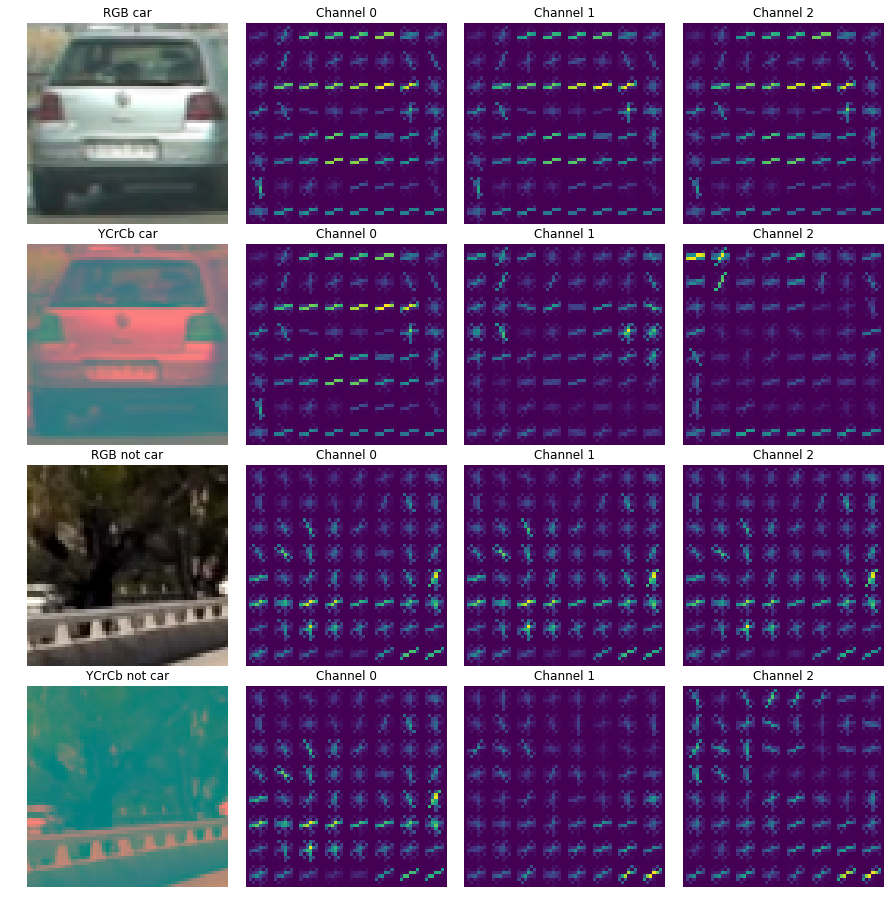

In [13]:
lmb_get_hog = lambda x : get_hog_features(x, orient = 9, pix_per_cell = 8, cell_per_block = 2,
                                          vis=True, feature_vec=True)

conv_rnd_car = convert_color(rnd_car, color_space='YCrCb')
conv_not_rnd_car = convert_color(rnd_not_car, color_space='YCrCb')

gray_rnd_car = convert_color(rnd_car, color_space='GRAY')
gray_not_rnd_car = convert_color(rnd_not_car, color_space='GRAY')


fig, axes = plt.subplots(4, 4, figsize=(12,12))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.05)

images = [rnd_car, conv_rnd_car, rnd_not_car, conv_not_rnd_car]
names = ['RGB car', 'YCrCb car', 'RGB not car', 'YCrCb not car']


for image, name, ax_line in zip(images, names, axes):
    ax_line[0].imshow(image)
    ax_line[0].set_title(name)
    ax_line[0].axis('off')
    for channel, ax in zip([0,1,2], ax_line[1:]):
        hog_feat, hog_img = lmb_get_hog(image[:,:,channel])
        ax.imshow(hog_img)
        ax.set_title('Channel '+str(channel))
        ax.axis('off')
fig.savefig('report-images/color-space-hog-features')

In [14]:
def feature_extraction(feat_extraction_fn, repo_path):

    ### Full car / notcars features
    car_features = lmd_extract_features(cars)
    notcar_features = lmd_extract_features(notcars)
    
    ### SCALE FEATURES
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    ### DEFINE LABELS VECTOR
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    ### TRAIN TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2)
    
    ### FIT SVC CLASSIFIER
    linear_svc = svm.LinearSVC()
    linear_svc.fit(X_train, y_train)
    
    ### Accuracy on the test set
    test_acc = accuracy_score(y_test, linear_svc.predict(X_test))
    
    # Save relevant data
    data = {}
    data['X_scaler'] = X_scaler
    data['X'] = scaled_X
    data['y'] = y
    data['test_acc'] = test_acc
    data['svc'] = linear_svc
    pickle.dump( data, open( repo_path, "wb" ) )
    
    return X_scaler, scaled_X, y, test_acc, linear_svc

In [15]:
### EXTRACT FEATURES
spatial = 32
histbin = 32
histrange=(0, 256)
color_space = 'YCrCb'
hog_channel = 0
ornt = 9
px_x_cell = 8
cll_x_block = 2

# Path to load / save data
repo_dir = 'data-repository'
path = '{}/cspc_{}_hgch_{}_{}{:0}{}_pickle.p'.format(repo_dir, color_space, hog_channel, ornt, px_x_cell, cll_x_block)
# Lambda function to simplify feature extraction
lmd_extract_features = lambda x : extract_features(x, color_space=color_space,
                                                   png2jpg = True,
                                                   spatial_size=(spatial, spatial),
                                                   hist_bins=histbin, hist_range=histrange,
                                                   pix_per_cell = px_x_cell, cell_per_block = cll_x_block, orient = ornt,
                                                   hog_channel=hog_channel,
                                                   spatial_feat = True, hist_feat = True, hog_feat = True)

try:
    with open(path, mode='rb') as f:
        data = pickle.load(f)
    X_scaler = data['X_scaler']
    X = data['X']
    y = data['y']
    test_acc = data['test_acc']
    linear_svc = data['svc']
except OSError as err:
    X_scaler, X, y, test_acc, linear_svc = feature_extraction(lmd_extract_features, path)
    
print('Test acuracy: ', test_acc)

Test acuracy:  0.976914414414


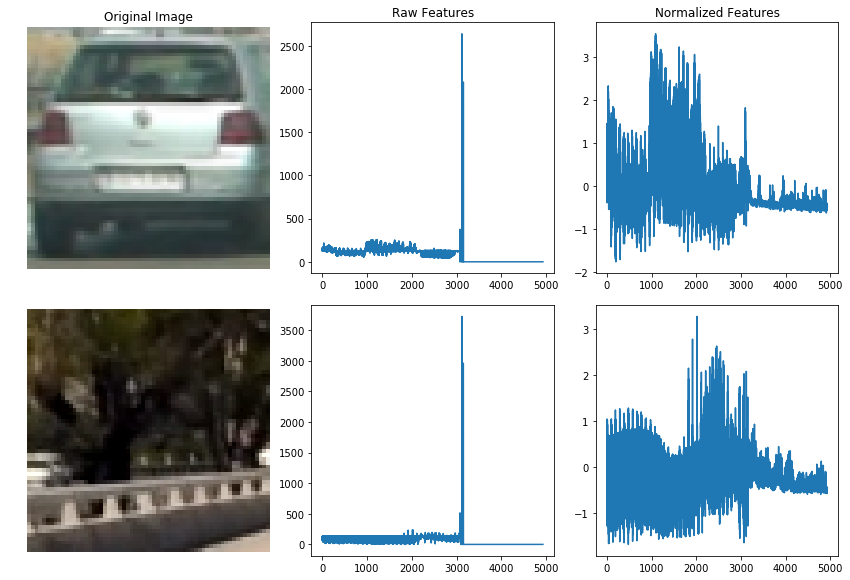

In [16]:
### Sample car / notcars features
rnd_car_features = lmd_extract_features([cars[rnd_car_id]])
rnd_notcar_features = lmd_extract_features([notcars[rnd_not_car_id]])

sample_X = np.vstack((rnd_car_features, rnd_notcar_features)).astype(np.float64)                        
scl_sample_X = X_scaler.transform(sample_X)

# Plot an example of raw and scaled features
fig, axes = plt.subplots(2, 3, figsize=(12,8))
fig.tight_layout()

ax11, ax12, ax13 = axes[0]
ax21, ax22, ax23 = axes[1]

ax11.imshow(rnd_car)
ax11.set_title('Original Image')
ax11.axis('off')

ax12.plot(sample_X[0])
ax12.set_title('Raw Features')

ax13.plot(scl_sample_X[0])
ax13.set_title('Normalized Features')

ax21.imshow(rnd_not_car)
#ax21.set_title('Original Image')
ax21.axis('off')

ax22.plot(sample_X[1])
#ax22.set_title('Raw Features')

ax23.plot(scl_sample_X[1])
#ax23.set_title('Normalized Features')

fig.savefig('report-images/car-notcar-normalize-features')

### Vehicle detection

In [17]:
# Lambda function to easily call find cars function
lmb_find_cars = lambda x: find_cars(x, ystart = 400, ystop = 656, scale = 1.5, color_space = color_space,
                                    svc= linear_svc, X_scaler = X_scaler,
                                    orient = ornt, pix_per_cell = px_x_cell, cell_per_block = cll_x_block,
                                    hog_channels = hog_channel,
                                    spatial_size = (32, 32), hist_bins = 32)

In [18]:
def full_image_pipeline(image):
    
    # 0. Process one in two images
    if the_counter.get_counter() % 2 == 0:
        the_counter.plus()
        
        # 1. detect cars
        tracker.find_cars(image)

        # 2. filter detections
        filtered_boxes = tracker.get_detection()

        # 3. draw boxes
        draw_img = draw_boxes(image, filtered_boxes)

        return draw_img

    else:
        the_counter.plus()
        
        # 2. used detection from previous frame
        filtered_boxes = tracker.get_detection()

        # 3. draw boxes
        draw_img = draw_boxes(image, filtered_boxes)
        
        return draw_img

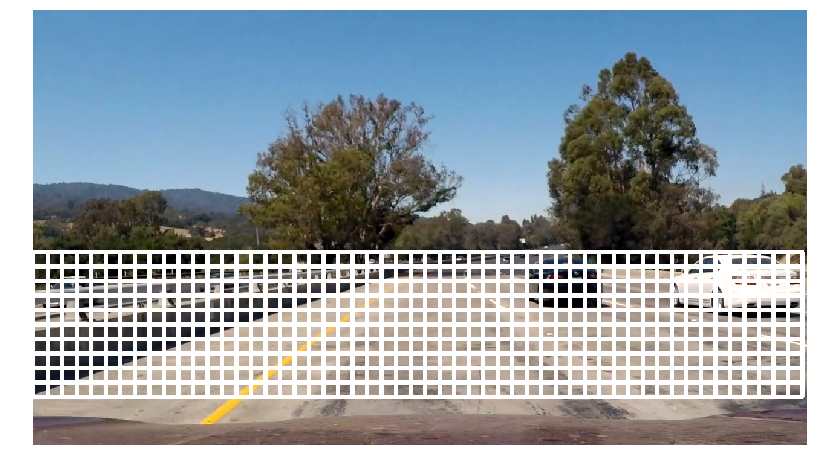

In [19]:
## Sliding window example
img_path = 'video-images/vid_img_001.jpg'
img = mpimg.imread(img_path)
boxes = slide_window(img, x_start_stop=[None, None], y_start_stop=(400,656), xy_window=(96,96), xy_overlap=(0.75,0.75))
draw_img = draw_boxes(img, boxes)
fig, ax1 = plt.subplots(1, figsize=(16,8))
ax1.imshow(draw_img)
ax1.axis('off')

fig.savefig('report-images/sliding-window')

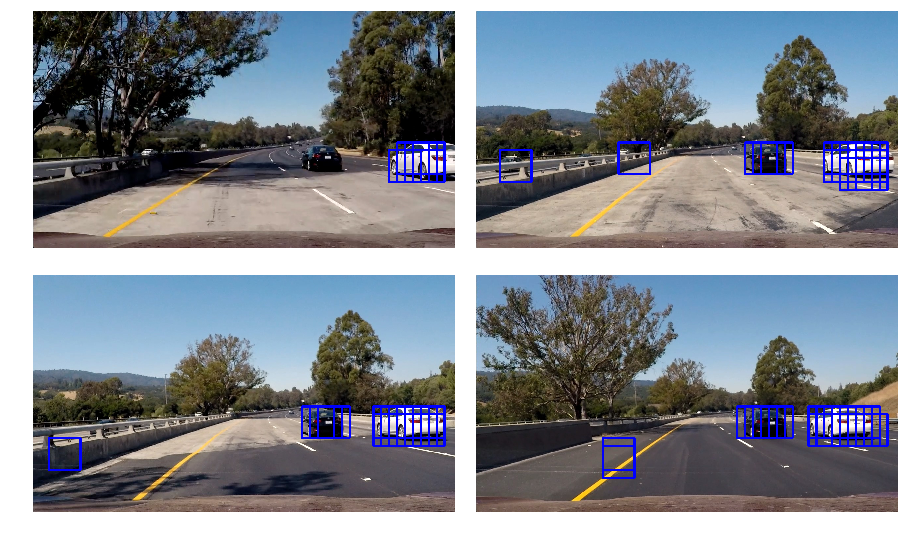

In [20]:
# Test images
paths = glob.glob('test_images/test0*.jpg')

boxed_imgs = []
for img_path in paths[:]:
    img = mpimg.imread(img_path)
    boxes = lmb_find_cars(img)
    draw_img = draw_boxes(img, boxes)
    boxed_imgs.append(draw_img)
    
fig, axes = plt.subplots(2,2, figsize=(12,7))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.05)

axes[0][0].imshow(boxed_imgs[0])
axes[0][0].axis('off')

axes[0][1].imshow(boxed_imgs[1])
axes[0][1].axis('off')

axes[1][0].imshow(boxed_imgs[2])
axes[1][0].axis('off')

axes[1][1].imshow(boxed_imgs[3])
axes[1][1].axis('off')

fig.savefig('report-images/car-detection')

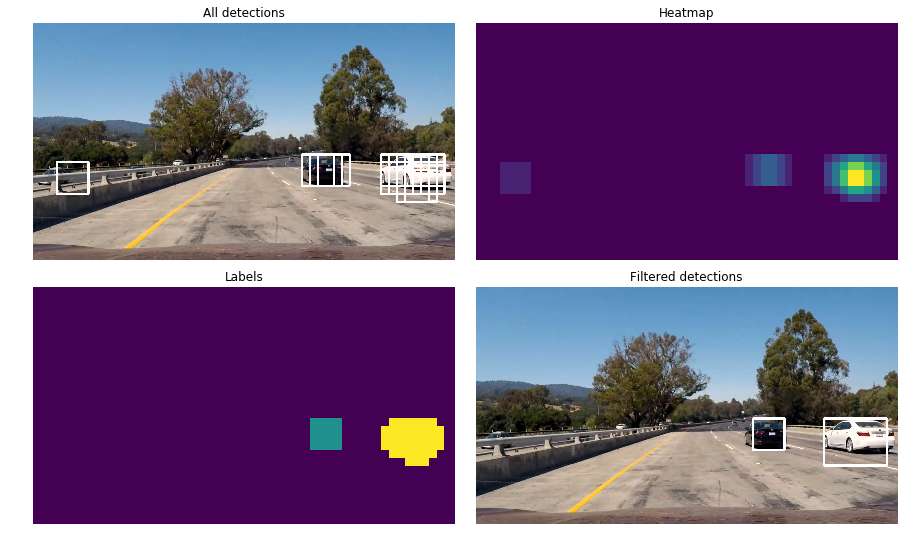

In [21]:
img_path = 'video-images/vid_img_001.jpg'
img = mpimg.imread(img_path)

the_counter = Counter()
tracker = VehicleTracker(find_func = lmb_find_cars, init_threshold = 1)
tracker.find_cars(img)
boxes = tracker.get_car_candidates()

draw_image = full_image_pipeline(img)
    
all_boxes = tracker.get_car_candidates()
all_boxed = draw_boxes(img, all_boxes)
    
heatmap = np.zeros_like(img[:,:,0])
heatmap = add_heat(heatmap, all_boxes)

label_img = heatmap.copy()
label_img = apply_threshold(label_img, tracker.treshold)
label_img = label(label_img)[0]
    
fig, axes = plt.subplots(2,2, figsize=(12,7))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.05)

axes[0][0].set_title('All detections', fontsize = 12)
axes[0][0].imshow(all_boxed)
axes[0][0].axis('off')

axes[0][1].set_title('Heatmap', fontsize = 12)
axes[0][1].imshow(heatmap)
axes[0][1].axis('off')

axes[1][0].set_title('Labels', fontsize = 12)
axes[1][0].imshow(label_img)
axes[1][0].axis('off')

axes[1][1].set_title('Filtered detections', fontsize = 12)
axes[1][1].imshow(draw_image)
axes[1][1].axis('off')

fig.savefig('report-images/detection-pipeline')

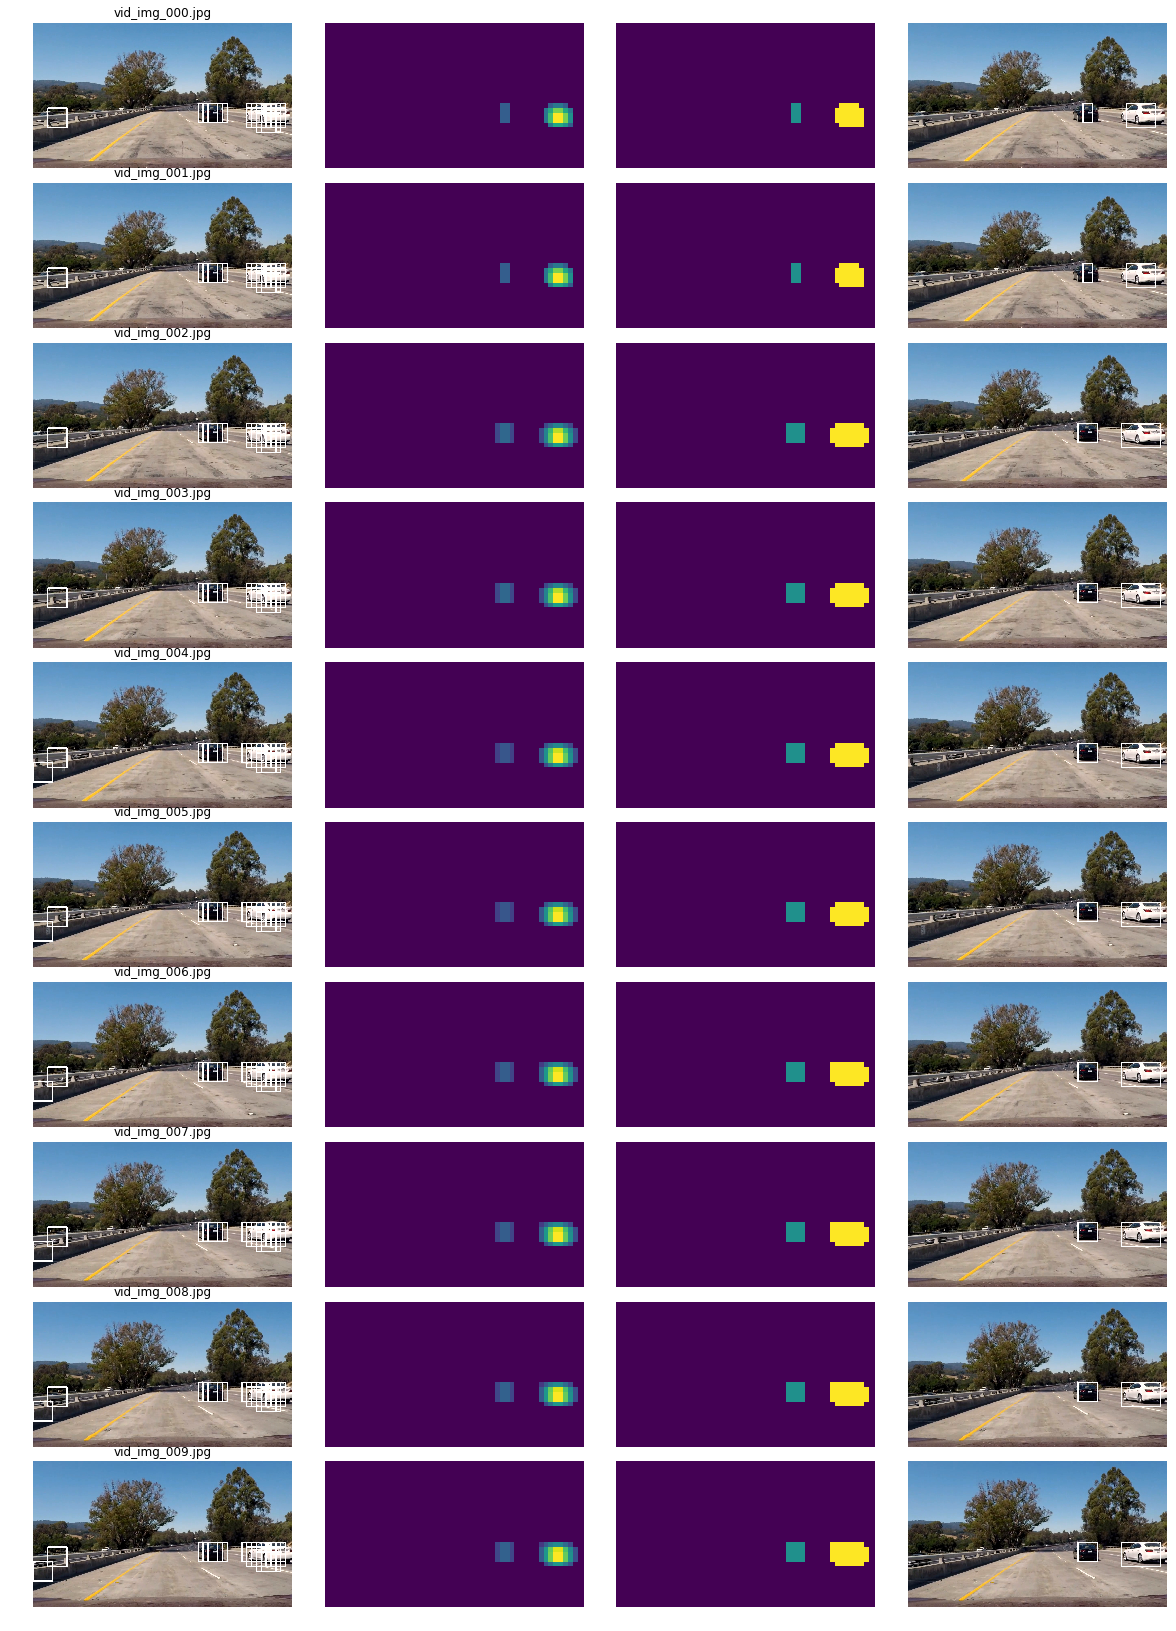

In [22]:
# Test images
paths = glob.glob('video-images/vid_img_00*.jpg')

the_counter = Counter()
tracker = VehicleTracker(find_func = lmb_find_cars, max_memory_len = 6, init_threshold = 1)

originals = []
all_boxes_imgs = []
heatmaps = []
labels = []
draw_images = []
for img_path in paths[:]:
    
    img = mpimg.imread(img_path)
    originals.append(img)
    draw_images.append(full_image_pipeline(img))
    
    all_boxes = tracker.get_car_candidates()
    all_boxes_imgs.append(draw_boxes(img, all_boxes))
    
    heatmap = np.zeros_like(img[:,:,0])
    heatmaps.append(add_heat(heatmap, all_boxes))
    
    heatmap = apply_threshold(heatmap, tracker.treshold)
    labels.append(label(heatmap)[0])
    
    all_boxes = tracker.get_car_candidates()

img_id_from = 0
fig, axes = plt.subplots(len(draw_images[img_id_from:]),4, figsize=(16,22))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.05)
for all_boxes, heatmap, labeled, draw_image, path, ax_line in zip(all_boxes_imgs[img_id_from:], heatmaps[img_id_from:],
                                                      labels[img_id_from:], draw_images[img_id_from:],
                                                      paths[img_id_from:], axes):
    ax_line[0].set_title(path.split('/')[-1])
    ax_line[0].axis('off')
    ax_line[0].imshow(all_boxes)
    ax_line[1].imshow(heatmap)
    ax_line[1].axis('off')
    ax_line[2].imshow(labeled)
    ax_line[2].axis('off')
    ax_line[3].imshow(draw_image)
    ax_line[3].axis('off')
fig.savefig('report-images/pipeline-in-sequence')

In [25]:
the_counter = Counter()
tracker = VehicleTracker(find_func = lmb_find_cars, max_memory_len = 6, init_threshold = 2)

video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(full_image_pipeline) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [11:15<00:00,  2.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [24]:
### Script for saving images from video

imgSaver =  ImageSaver('video-images')       
video_output = 'temp.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(40,42)
white_clip = clip1.fl_image(img_saver) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 98%|█████████▊| 50/51 [00:49<00:00,  1.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

